In [2]:
import sys
from time import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.feature import StandardScaler

In [4]:
def extract_label(fields):
    label = (fields[-1])
    return float(label)

def extract_features(fields,categoriesMap,featureEnd):
    categoryIdx = categoriesMap[fields[3]]
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    numericalFeatures = [convert_float(field) for field in fields[4:featureEnd]]
    return np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    ret=(0 if x=='?' else float(x))
    return (0 if ret<0 else ret)


In [5]:
def PrepareData(sc):
    global Path
    if sc.master[0:5]=='local':
       Path = "file:/home/hadoop/pythonwork/data/stumbleupon" 
    else:
       Path = "hdfs:/user/hduser/MovieRecom/stumbleupon" 
    
    print 'data loading..'
    rawDataWithHeader = sc.textFile(Path+'/train.tsv')
    header = rawDataWithHeader.first()
    rawData = rawDataWithHeader.filter(lambda x:x != header)
    rData = rawData.map(lambda x: x.replace("\"",""))
    lines = rData.map(lambda x:x.split("\t"))
    print str(lines.count())
    #-----------construct the training data RDD[LabeledPoint]
    print "Before Normalzation.. \n"
    categoriesMap = lines.map(lambda fields:fields[3])\
                         .distinct().zipWithIndex().collectAsMap()
    labelRDD = lines.map(lambda r: extract_label(r))
    featureRDD = lines.map(lambda r: extract_features(r, categoriesMap, len(r)-1)) 
    for i in featureRDD.first():
        print (str(i)+","),
    print "\n"+"After Normalzation.. \n"
    stdScalar = StandardScaler(withMean=False, withStd=True).fit(featureRDD)
    #print type(stdScalar)
    ScalerFeatureRDD = stdScalar.transform(featureRDD)
    for i in ScalerFeatureRDD.first():
        print (str(i)+","),
    labelpoint = labelRDD.zip(ScalerFeatureRDD)
    labelpointRDD = labelpoint.map(lambda r: LabeledPoint(r[0], r[1]))
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print('\n'+'trainData size:'+str(trainData.count())+ 
          ', validData size:'+str(validationData.count())+
          ', testData size:'+str(testData.count()))
    return (trainData, validationData, testData)        

In [6]:
(trainData, validationData, testData) = PrepareData(sc)
trainData.persist()
validationData.persist()
testData.persist()

data loading..
7395
Before Normalzation.. 

0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.789131, 2.055555556, 0.676470588, 0.205882353, 0.047058824, 0.023529412, 0.443783175, 0.0, 0.0, 0.09077381, 0.0, 0.245831182, 0.003883495, 1.0, 1.0, 24.0, 0.0, 5424.0, 170.0, 8.0, 0.152941176, 0.079129575, 
After Normalzation.. 

0.0, 3.08823447037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.38210990583, 0.238469258742, 3.33017936032, 1.40301544772, 0.490307355432, 0.323968347813, 0.0777978299323, 0.0, 0.0, 2.19018963312, 0.0, 4.68369735582, 0.00206688652554, 2.05550839928, 2.11132763706, 1.1768686024, 0.0, 0.611125152837, 0.947253587774, 2.4743966777, 0.83444157063, 0.998721352144, 
trainData size:5950, validData size:692, testData size:753


PythonRDD[27] at RDD at PythonRDD.scala:48

In [7]:
def evaluateModel(model, validationData):    
    score = model.predict(validationData.map(lambda p: p.features)).map(lambda x: float(x)) #modify by myself
    scoreAndLabels = score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC = metrics.areaUnderROC
    return(AUC)  

def trainEvaluateModel(trainData, validationData, lambdaParm):
    startTime = time()
    model = NaiveBayes.train(trainData, lambdaParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print "train evaluation(params):" +\
    ", lambda="+str(lambdaParm)+"\n"+\
    "==>required time:"+str(duration)+\
    " ,AUC="+str(AUC)
    return (AUC, duration, lambdaParm, model)

In [8]:
#BinaryClassificationMetrics Testing

model = NaiveBayes.train(trainData, 5.0)
score = model.predict(validationData.map(lambda p: p.features)).map(lambda x: float(x))
scoreAndLabels = score.zip(validationData.map(lambda p: p.label))

print score.take(5)
print validationData.map(lambda p: p.label).take(5)
print scoreAndLabels.take(5)
sub_pairs = sc.parallelize(scoreAndLabels.take(5))
print type(sub_pairs)
print sub_pairs.collect()
metrics = BinaryClassificationMetrics(sub_pairs)
AUC = metrics.areaUnderROC
print AUC

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 1.0, 0.0, 1.0]
[(1.0, 1.0), (0.0, 0.0), (0.0, 1.0), (0.0, 0.0), (0.0, 1.0)]
<class 'pyspark.rdd.RDD'>
[(1.0, 1.0), (0.0, 0.0), (0.0, 1.0), (0.0, 0.0), (0.0, 1.0)]
0.666666666667


In [9]:
sc.master

u'local[*]'

In [11]:
def showchart(df, evalparm, barData, lineData, yMin, yMax):
    ax = df[barData].plot(kind='bar', title=evalparm, figsize=(10,6), legend=True, fontsize=12)
    ax.set_xlabel(evalparm, fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData, fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData].values, linestyle='-', marker='o', linewidth=2.0, color='r')
    plt.show()
    
def evalParameter(trainData, validationData, evalparm, lambdaParmList):
    metrics = [trainEvaluateModel(trainData, validationData, lambdaParm)
               for lambdaParm in lambdaParmList]
    
    if evalparm == "lambdaParm":
       IndexList=lambdaParmList[:] 
   
    df = pd.DataFrame(metrics, index=IndexList,
                  columns=["AUC", "duration", "lambdaParm", "model"])
    showchart(df, evalparm, 'AUC', 'duration', 0.5, 0.7)

train evaluation(params):, lambda=1.0
==>required time:1.17403507233 ,AUC=0.639109325297
train evaluation(params):, lambda=3.0
==>required time:0.460036993027 ,AUC=0.639109325297
train evaluation(params):, lambda=5.0
==>required time:0.491184949875 ,AUC=0.639109325297
train evaluation(params):, lambda=15.0
==>required time:0.444716215134 ,AUC=0.640490540767
train evaluation(params):, lambda=25.0
==>required time:0.401885986328 ,AUC=0.640490540767
train evaluation(params):, lambda=30.0
==>required time:0.401713132858 ,AUC=0.640490540767
train evaluation(params):, lambda=35.0
==>required time:0.429584026337 ,AUC=0.640490540767
train evaluation(params):, lambda=40.0
==>required time:0.350908041 ,AUC=0.640490540767
train evaluation(params):, lambda=45.0
==>required time:0.470574140549 ,AUC=0.640490540767
train evaluation(params):, lambda=50.0
==>required time:0.474599123001 ,AUC=0.640490540767
train evaluation(params):, lambda=60.0
==>required time:0.473206996918 ,AUC=0.640356604721


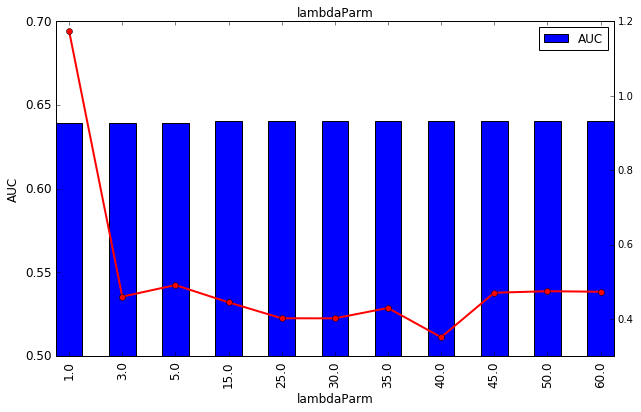

In [12]:
evalParameter(trainData, validationData, 
              "lambdaParm", lambdaParmList=[1.0, 3.0, 5.0, 15.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 60.0])

# Evaluation Process:multi-variables

In [16]:
def evalAllParameter(trainData, validationData, lambdaParmList):
    metrics = [trainEvaluateModel(trainData, validationData, lambdaParm)
               for lambdaParm in lambdaParmList]
    
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter = Smetrics[0]
    print("The best parameters: numIterations:" + str(bestParameter[2])+

                               "\n, AUC = " + str(bestParameter[0]) 
         ) 
    
    return bestParameter[5]

In [17]:
model = evalAllParameter(trainData, validationData, 
                         [5, 15, 25], [10, 50, 200], [0.01, 0.1, 1])

train evaluation(params):numIterations=5, stepSize=10, regPram=0.01
==>required time:0.96582698822 ,AUC=0.617940363002
train evaluation(params):numIterations=5, stepSize=10, regPram=0.1
==>required time:0.594581842422 ,AUC=0.575573743956
train evaluation(params):numIterations=5, stepSize=10, regPram=1
==>required time:0.686473846436 ,AUC=0.652896342536
train evaluation(params):numIterations=5, stepSize=50, regPram=0.01
==>required time:0.567826986313 ,AUC=0.579574644775
train evaluation(params):numIterations=5, stepSize=50, regPram=0.1
==>required time:0.725914001465 ,AUC=0.638240448157
train evaluation(params):numIterations=5, stepSize=50, regPram=1
==>required time:0.718559980392 ,AUC=0.651506407775
train evaluation(params):numIterations=5, stepSize=200, regPram=0.01
==>required time:0.696646928787 ,AUC=0.570098456645
train evaluation(params):numIterations=5, stepSize=200, regPram=0.1
==>required time:0.734660863876 ,AUC=0.651506407775
train evaluation(params):numIterations=5, stepSi